# Импорты

In [1]:
from obspy import read
from matplotlib import pyplot as plt
import pandas as pd

import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from obspy.imaging.cm import pqlx
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

from obspy.core.inventory.inventory import Inventory
from obspy.core.inventory.network import Network
from obspy.core.inventory.station import Station
from obspy.core.inventory.channel import Channel
from obspy.core.inventory.util import Site

from obspy.io.mseed.util import get_record_information
from obspy.core.inventory.inventory import read_inventory

from obspy.signal.invsim import corn_freq_2_paz

from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import trigger_onset
from obspy.signal.trigger import z_detect
from obspy.signal.trigger import recursive_sta_lta

from obspy.core.inventory.response import Response

%load_ext autoreload
%autoreload 2
import seismosocialdistancing

# Константы

In [19]:
sensitivity = 2.59 # В/м 

station = "3388" # Станция
path1 = f".\\010 - Source\\*{station}*\*" # Путь к минисидам
dataset = f"{station}_Proc" # Префикс для сохранения
# channel_proc = "EQN" # Обрабатываемый канал
channel_proc = "EQZ" # Обрабатываемый канал
# channel_proc = "EQZ" # Обрабатываемый канал

# Отклик акселерометра

In [3]:
a = 0.4142212012175968
b = 0
paz_1hz = corn_freq_2_paz(0.1, damp=0.707)
paz_1hz['gain'] = 1
paz_1hz['sensitivity'] = 1/sensitivity
# paz_1hz['poles'] = [(-a-b*1j), (-a+b*1j)]
# paz_1hz['zeros'] = [0j, 0j, 0j]
paz_1hz['stage_gain'] = 1
paz_1hz

{'poles': [(-0.4442212012175968-0.44435537628385885j),
  (-0.4442212012175968+0.44435537628385885j)],
 'zeros': [0j, 0j],
 'gain': 1,
 'sensitivity': 0.3861003861003861,
 'stage_gain': 1}

In [69]:
resp = Response.from_paz(zeros=paz_1hz["zeros"], poles=paz_1hz["poles"], stage_gain=1, input_units='M/S')
resp

Channel Response
	From M/S () to VOLTS ()
	Overall Sensitivity: 0.999953 defined at 1.000 Hz
	1 stages:
		Stage 1: PolesZerosResponseStage from M/S to VOLTS, gain: 1

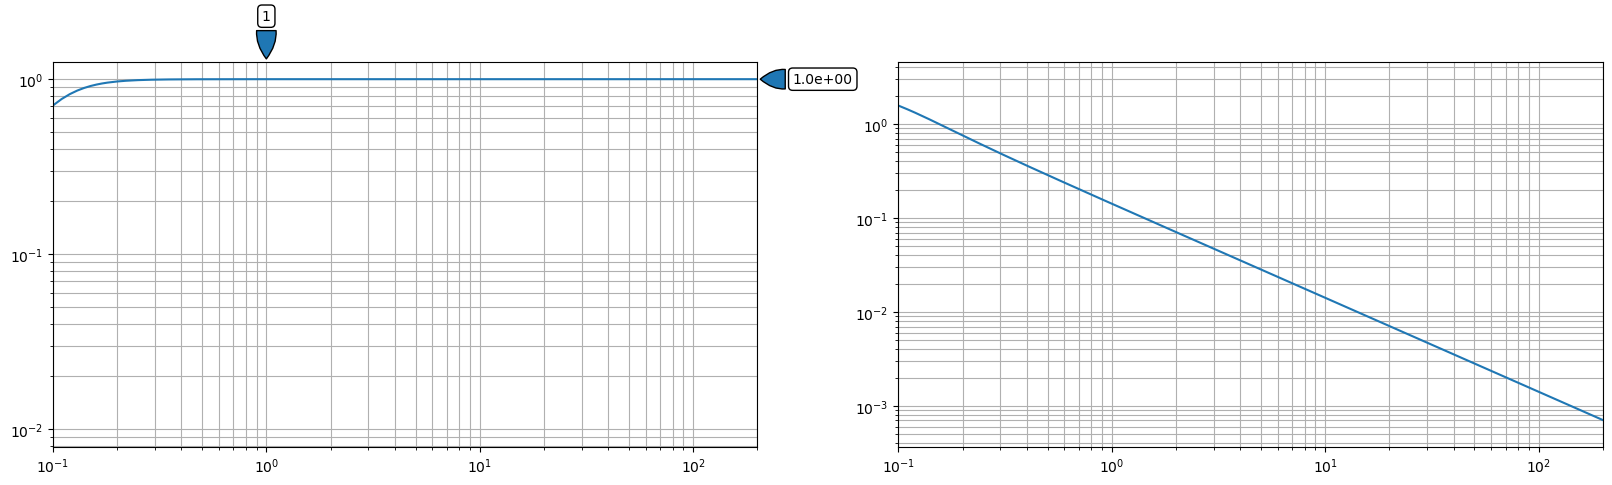

In [70]:
resp = Response.from_paz(zeros=paz_1hz["zeros"], poles=paz_1hz["poles"], stage_gain=paz_1hz['stage_gain'], input_units='M/S**2')
fig, axs = plt.subplots(1, 2, figsize=(20,5))

resp.plot(min_freq=0.01, output='ACC', sampling_rate=500, axes=[axs[0], axs[1]], show=False)
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.1, 200])
    # ax.set_ylim([0.5, 1.1])
    ax.grid(which='minor')
    ax.grid(which='major')
plt.show()

# Загрузка данных

In [71]:
files_wh = glob(path1)

In [4]:
st = read(path1).select(channel=channel_proc).sort(keys=['starttime'])
print(st.__str__(extended=True))

C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: D3_3388_33_EQZ_D: Warning: Data offset in fixed header (68) is within the blockette chain ending at 72
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: D3_3388_33_EQN_D: Warning: Data offset in fixed header (68) is within the blockette chain ending at 72
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: D3_3388_33_EQE_D: Warning: Data offset in fixed header (68) is within the blockette chain ending at 72
  warnings.warn(_w, InternalMSEEDWarning)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\io\mseed\headers.py:823: InternalMSEEDWarning: readMSEEDBuffer(): Last record only has 68 byte(s) which is not enough to constitute a full SEED record. Corrupt data? Record will be skipped.
  

377 Trace(s) in Stream:
D3.3388.33.EQZ | 2024-01-25T13:17:22.000000Z - 2024-01-25T13:47:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T13:47:22.000000Z - 2024-01-25T14:17:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T14:13:16.001000Z - 2024-01-25T15:13:15.999000Z | 500.0 Hz, 1800000 samples
D3.3388.33.EQZ | 2024-01-25T14:17:22.000000Z - 2024-01-25T14:47:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T14:47:22.000000Z - 2024-01-25T15:17:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T15:13:16.000000Z - 2024-01-25T16:13:15.998000Z | 500.0 Hz, 1800000 samples
D3.3388.33.EQZ | 2024-01-25T15:17:22.000000Z - 2024-01-25T15:47:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T15:47:22.000000Z - 2024-01-25T16:17:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T16:13:16.000000Z - 2024-01-25T16:14:55.902000Z | 500.0 Hz, 49952 samples
D3.3388.33.EQZ | 2024-01-25T16:17:22.000000Z - 2024-01-25

# Удаление коротышей

In [5]:
for tr in st:
    if len(tr.data)<100000:
        st.remove(tr)
print(st.__str__(extended=True))

376 Trace(s) in Stream:
D3.3388.33.EQZ | 2024-01-25T13:17:22.000000Z - 2024-01-25T13:47:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T13:47:22.000000Z - 2024-01-25T14:17:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T14:13:16.001000Z - 2024-01-25T15:13:15.999000Z | 500.0 Hz, 1800000 samples
D3.3388.33.EQZ | 2024-01-25T14:17:22.000000Z - 2024-01-25T14:47:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T14:47:22.000000Z - 2024-01-25T15:17:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T15:13:16.000000Z - 2024-01-25T16:13:15.998000Z | 500.0 Hz, 1800000 samples
D3.3388.33.EQZ | 2024-01-25T15:17:22.000000Z - 2024-01-25T15:47:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T15:47:22.000000Z - 2024-01-25T16:17:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T16:17:22.000000Z - 2024-01-25T16:47:21.998000Z | 500.0 Hz, 900000 samples
D3.3388.33.EQZ | 2024-01-25T16:47:22.000000Z - 2024-01-2

# Тестирование подавления отклика

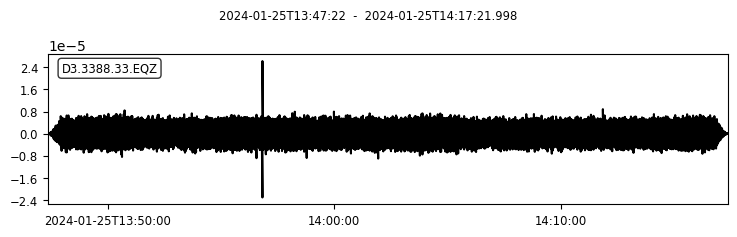

Sensetivity check - 2.590391165232361


In [77]:
paz_1hz = corn_freq_2_paz(0.1, damp=0.707)
paz_1hz['gain'] = 1
paz_1hz['sensitivity'] = 1/sensitivity

NN = 1
st_ed = st.copy()
st_ed[NN].simulate(paz_simulate=paz_1hz)
st_ed[NN].plot()

razm1 = (st[NN].data.max()-st[NN].data.min())
razm2 = (st_ed[NN].data.max()-st_ed[NN].data.min())

print("Sensetivity check -", razm1/razm2)

## До/после

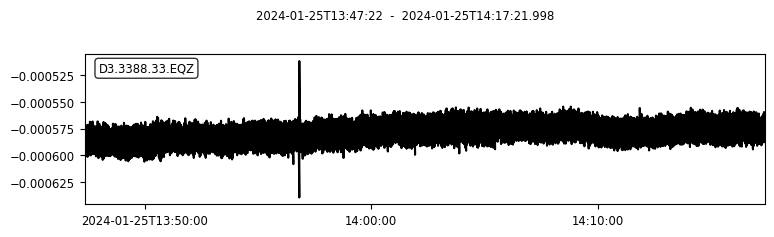

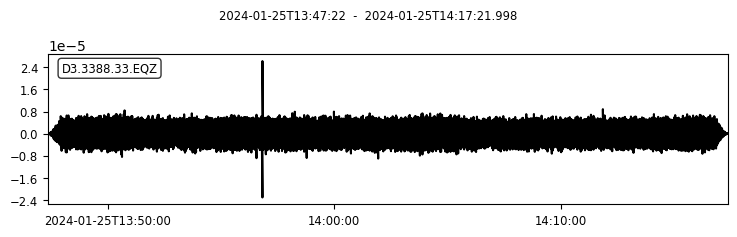

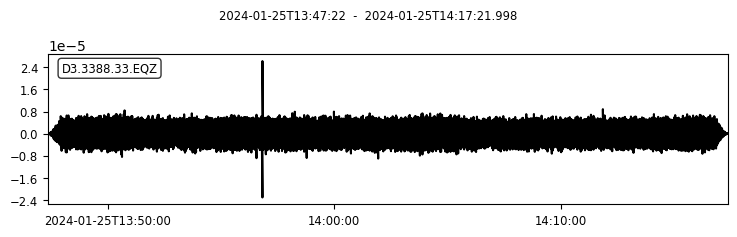

In [78]:
st[NN].plot()
st_ed[NN].plot()

## Dayplot до подавления отклика

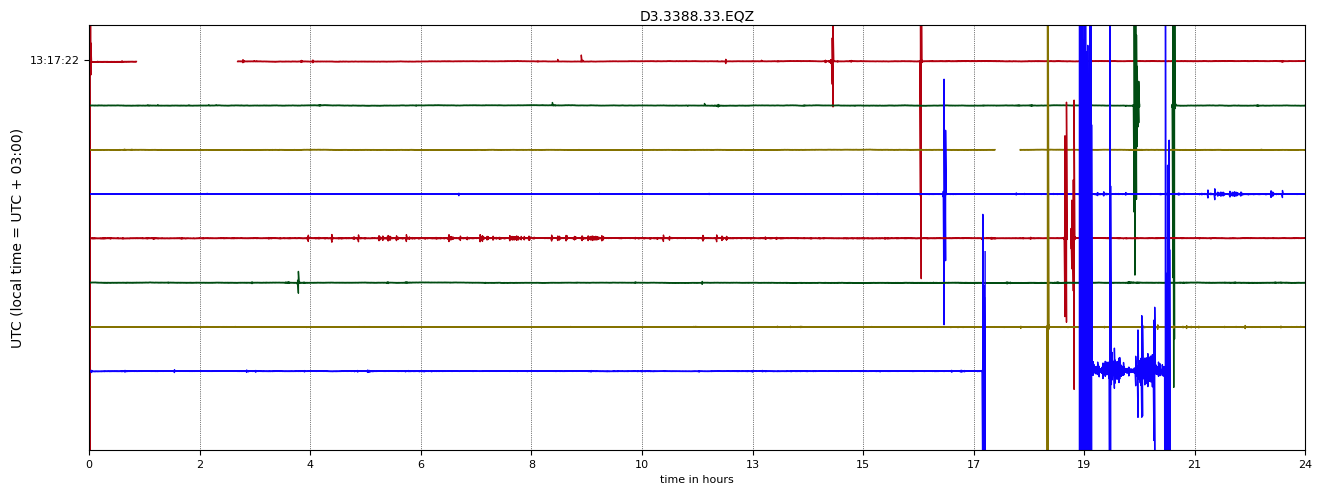

In [79]:
_ = st.plot(type='dayplot', interval=1440, size=(1600, 500))

## Удаление отклика во всем потоке

In [80]:
st = st.simulate(
    paz_simulate=paz_1hz,
)

## Dayplot после подавления отклика

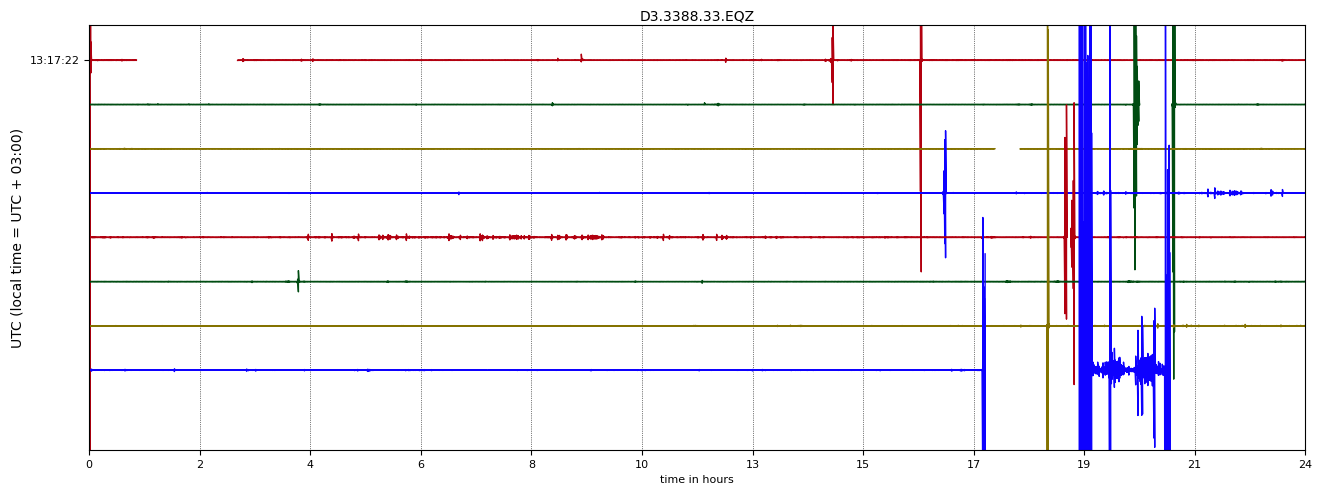

In [81]:
_ = st.plot(type='dayplot', interval=1440, size=(1600, 500))

# Удаление антропогенного шума

In [6]:
st_edit = st.copy()
st_z = st.copy()

## Trigger methods

In [83]:
lower_big = 1.7
upper_big = 0.5

df=st_z[0].stats.sampling_rate
z_win = int(200*df)

st_z.trigger('zdetect', nsta=z_win)
onsets = [trigger_onset(st_z_el.data, lower_big, upper_big, max_len=600*df, max_len_delete=True) for st_z_el in st_z]

for i, onset in enumerate(tqdm.tqdm(onsets)):
    for pair in onset:
        if st_z[i].data.min() > -0.5:
            p1 = pair[0] - z_win if pair[0] >= z_win else 0
            p2 = pair[1] + z_win if pair[1] <= len(st_z[i].data) - z_win else len(st_z[i].data)
            t1 = st_z[i].stats.starttime+p1/df
            t2 = st_z[i].stats.starttime+p2/df
            st_edit.cutout(t1, t2)

100%|███████████████████████████████████████████████████████████████████████████████| 376/376 [00:02<00:00, 156.01it/s]


## Dayplot после подавления антропогенных помех

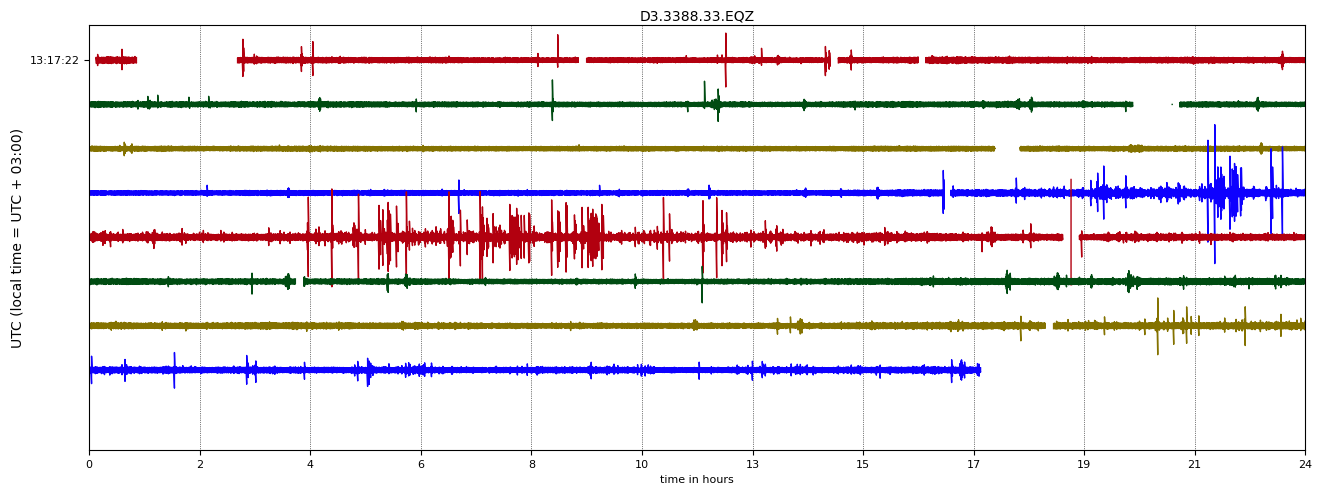

In [90]:
_ = st_edit[:-5].plot(type='dayplot', interval=1440, size=(1600, 500))

## Ручное удаление (опционально!)

In [ ]:
# print(st_edit.__str__(extended=True))

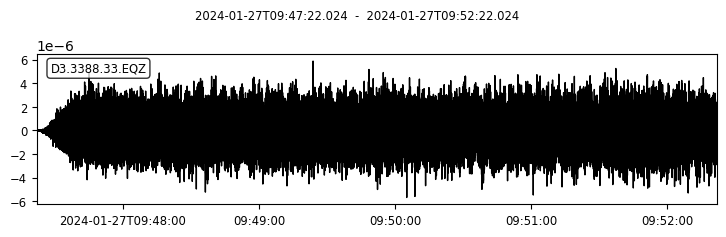

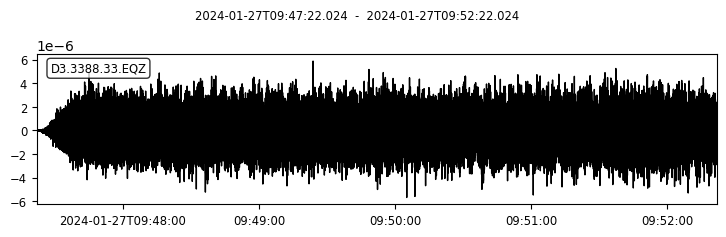

In [89]:
NN = 96
st_edit[NN].plot()

In [88]:
NN = 96
t1 = st_edit[NN].stats.starttime+5*60
t2 = st_edit[NN].stats.endtime
st_edit.cutout(t1, t2)

389 Trace(s) in Stream:

D3.3388.33.EQZ | 2024-01-25T13:17:22.000000Z - 2024-01-25T13:17:22.000000Z | 500.0 Hz, 1 samples
...
(387 other traces)
...
D3.3388.33.EQZ | 2024-02-02T10:19:29.000000Z - 2024-02-02T10:36:45.126000Z | 500.0 Hz, 518064 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

# Построение PPSD

## Выделение нужной части потока

In [7]:
st_edit_fin = st_edit[:-5].copy()

In [8]:
datelist = pd.date_range(st_edit_fin[0].stats.starttime.datetime, st_edit_fin[-1].stats.endtime.datetime, freq="D")
datelist

DatetimeIndex(['2024-01-25 13:17:22', '2024-01-26 13:17:22',
               '2024-01-27 13:17:22', '2024-01-28 13:17:22',
               '2024-01-29 13:17:22', '2024-01-30 13:17:22',
               '2024-01-31 13:17:22', '2024-02-01 13:17:22'],
              dtype='datetime64[ns]', freq='D')

In [9]:
paz = {'gain': 1,
       'poles': [],
       'sensitivity': 1,
       'zeros': [],
       'stage_gain': 1}

## Расчет PPSD

In [94]:
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_in = "{}_{}_{channel}.mseed".format(dataset, datestr, channel=channel_proc)
    pbar.set_description("Processing %s" % fn_in)
    fn_out = "{}_{}_{channel}.npz".format(dataset, datestr, channel=channel_proc)
    st_buff = st_edit_fin.slice(starttime=UTCDateTime(day)-1801,
                   endtime=UTCDateTime(day)+86400+1801,
                  )
    ppsd = PPSD(st_edit_fin[0].stats,
                paz, # Здесь используется плоский response, потому что он был удален ранее, на этапе обработки
                # paz_1hz,
                ppsd_length=1800,
                overlap=0,
                period_limits=(0.01, 100),
                db_bins=(-200, 20, 0.25),
                skip_on_gaps=True,
                special_handling='ringlaser',
               )
    ppsd.add(st_buff)
    ppsd.save_npz(fn_out[:-4])
    del st_buff, ppsd

Processing 3388_Proc_2024-01-25_EQZ.mseed:   0%|                                                 | 0/8 [00:00<?, ?it/s]C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\signal\spectral_estimation.py:885: UserWarning: Trace is shorter than this PPSD's 'ppsd_length' (1800 seconds). Skipping trace: D3.3388.33.EQZ | 2024-01-25T13:17:22.000000Z - 2024-01-25T13:17:22.000000Z | 500.0 Hz, 1 samples
  warnings.warn(msg)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\signal\spectral_estimation.py:885: UserWarning: Trace is shorter than this PPSD's 'ppsd_length' (1800 seconds). Skipping trace: D3.3388.33.EQZ | 2024-01-25T14:13:16.001000Z - 2024-01-25T14:13:16.003000Z | 500.0 Hz, 2 samples
  warnings.warn(msg)
C:\Users\Andrey\.conda\envs\obspy\lib\site-packages\obspy\signal\spectral_estimation.py:885: UserWarning: Trace is shorter than this PPSD's 'ppsd_length' (1800 seconds). Skipping trace: D3.3388.33.EQZ | 2024-01-25T14:23:09.634000Z - 2024-01-25T14:47:21.998000Z | 500.0 Hz, 

## Загрузка PPSD

In [13]:
# channel_proc = "EQN"

In [20]:
ppsds = {}
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_pattern = "{}_{}_{channel}.npz".format(dataset, datestr, channel=channel_proc)
    pbar.set_description("Reading %s" % fn_pattern)
    for fn in glob(fn_pattern):
        mseedid = f"{station} " + fn.replace(".npz", "").split("_")[-1]
        if mseedid not in ppsds:
            ppsds[mseedid] = PPSD.load_npz(fn)#, allow_pickle=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ppsds[mseedid].add_npz(fn)#, allow_pickle=True)

Reading 3388_Proc_2024-02-01_EQZ.npz: 100%|██████████████████████████████████████████████| 8/8 [00:00<00:00, 97.79it/s]


# Построение графиков

In [21]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

In [22]:
specs = [ppsd for mseedid, ppsd in ppsds.items()]

In [23]:
periods, mode_ = specs[0].get_mode()
periods # Массив периодов

array([1.00000000e-02, 1.09050773e-02, 1.18920712e-02, 1.29683955e-02,
       1.41421356e-02, 1.54221083e-02, 1.68179283e-02, 1.83400809e-02,
       2.00000000e-02, 2.18101547e-02, 2.37841423e-02, 2.59367911e-02,
       2.82842712e-02, 3.08442165e-02, 3.36358566e-02, 3.66801617e-02,
       4.00000000e-02, 4.36203093e-02, 4.75682846e-02, 5.18735822e-02,
       5.65685425e-02, 6.16884330e-02, 6.72717132e-02, 7.33603235e-02,
       8.00000000e-02, 8.72406186e-02, 9.51365692e-02, 1.03747164e-01,
       1.13137085e-01, 1.23376866e-01, 1.34543426e-01, 1.46720647e-01,
       1.60000000e-01, 1.74481237e-01, 1.90273138e-01, 2.07494329e-01,
       2.26274170e-01, 2.46753732e-01, 2.69086853e-01, 2.93441294e-01,
       3.20000000e-01, 3.48962474e-01, 3.80546277e-01, 4.14988657e-01,
       4.52548340e-01, 4.93507464e-01, 5.38173706e-01, 5.86882588e-01,
       6.40000000e-01, 6.97924949e-01, 7.61092554e-01, 8.29977315e-01,
       9.05096680e-01, 9.87014928e-01, 1.07634741e+00, 1.17376518e+00,
      

In [39]:
sr_10hz = np.array(specs[0].psd_values)[:,0]
sr_1hz = np.array(specs[0].psd_values)[:,53]
sr_01hz = np.array(specs[0].psd_values)[:,-28]

In [43]:
sr_df = pd.DataFrame(np.array([sr_10hz, sr_1hz, sr_01hz]).T, columns=["10 Hz", "1 Hz", "0.1 Hz"])
sr_df

,10 Hz,1 Hz,0.1 Hz
0,-142.581024,-138.675797,-126.114044
1,-138.263657,-126.835091,-114.824028
2,-141.346024,-113.593819,-101.239464
3,-142.681946,-138.104568,-121.366341
4,-143.245773,-138.757538,-126.900597
...,...,...,...
347,-143.345764,-139.104141,-124.170982
348,-143.780472,-139.135696,-127.457085
349,-142.680344,-138.892242,-126.253174
350,-143.720901,-138.966202,-126.432907


Text(0.5, 0, 'Amplitude, dB')

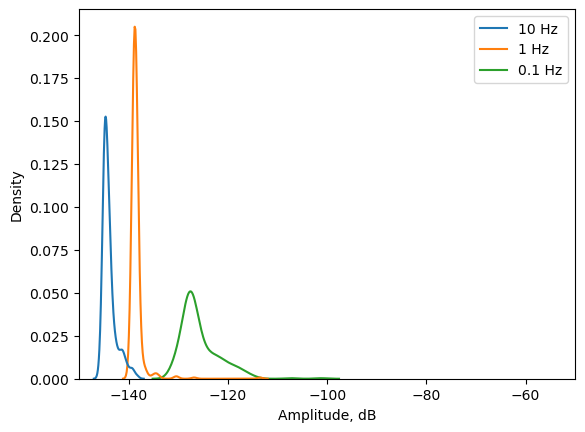

In [50]:
import seaborn as sns
sns.kdeplot(data=sr_df)
plt.gca().set_xlim([-150, -50])
plt.gca().set_xlabel("Amplitude, dB")

In [38]:
1/periods[-28]

0.09765624999999994

## График RMS смещений с процентилями

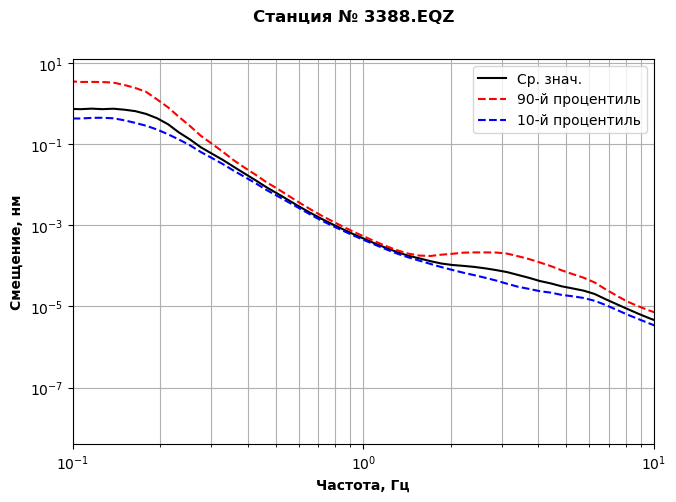

In [99]:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 5))
perc90 = np.percentile(np.array(specs[0].psd_values), 90, axis=0)
perc50 = np.percentile(np.array(specs[0].psd_values), 50, axis=0)
perc10 = np.percentile(np.array(specs[0].psd_values), 10, axis=0)

w = 2.0 * np.pi * (1/periods)
w = w[::-1]

fig.suptitle(f"Станция № {station}.{channel_proc}", fontweight='bold')
axs.plot(1/periods, 1e9*(w**2)*10**(perc50/10), c='k', label='Ср. знач.')
axs.plot(1/periods, 1e9*(w**2)*10**(perc90/10), '--r', label='90-й процентиль')
axs.plot(1/periods, 1e9*(w**2)*10**(perc10/10), '--b', label='10-й процентиль')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim([0.1, 10])
# a1].set_ylim([1e-5, 1e1])
axs.grid(which='minor')
axs.grid()
axs.set_xlabel("Частота, Гц", fontweight='bold')
axs.set_ylabel("Смещение, нм", fontweight='bold')
axs.legend()
plt.show()

# Список значений для таблички

In [100]:
for elem in np.array([w, 1e9*(w**2)*10**(perc90/10)]).T:
    print(elem)

[5.91430444e-02 2.29899278e-08]
[6.44959473e-02 4.11351144e-08]
[7.03333292e-02 6.23720143e-08]
[7.66990394e-02 8.88870673e-08]
[8.36408955e-02 1.17463465e-07]
[9.12110434e-02 1.56575206e-07]
[9.94663481e-02 2.03945095e-07]
[1.08468822e-01 2.59756150e-07]
[1.18286089e-01 3.24522867e-07]
[1.28991895e-01 4.00578652e-07]
[1.40666658e-01 4.79758853e-07]
[1.53398079e-01 5.90704209e-07]
[1.67281791e-01 7.06286536e-07]
[1.82422087e-01 8.63200022e-07]
[1.98932696e-01 1.02817895e-06]
[2.16937643e-01 1.24226392e-06]
[2.36572178e-01 1.55524220e-06]
[2.57983789e-01 2.02413508e-06]
[2.81333317e-01 2.53802801e-06]
[3.06796158e-01 2.97541815e-06]
[3.34563582e-01 3.22951218e-06]
[3.64844173e-01 3.44190158e-06]
[3.97865392e-01 3.95740836e-06]
[4.33875287e-01 4.57937794e-06]
[4.73144355e-01 4.92289015e-06]
[5.15967578e-01 5.22717246e-06]
[5.62666634e-01 6.38601755e-06]
[6.13592315e-01 7.92679325e-06]
[6.69127164e-01 1.01026283e-05]
[7.29688347e-01 1.31571580e-05]
[7.95730785e-01 1.85474032e-05]
[8.67750

## PPSD графики

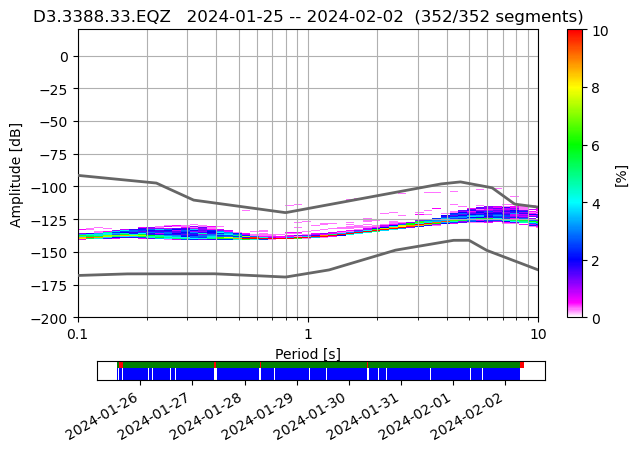

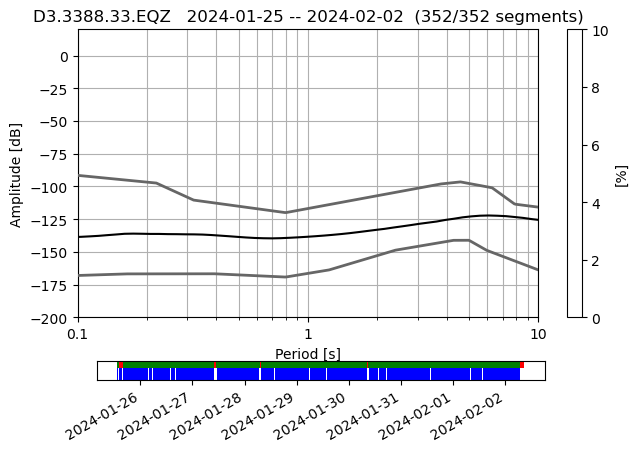

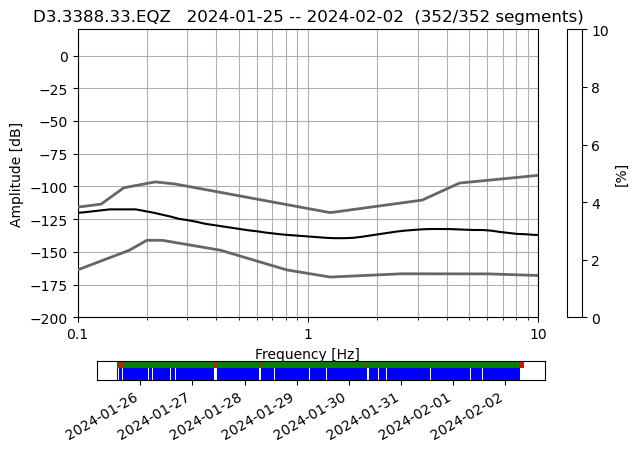

[None]

In [101]:
[ppsd.plot(max_percentage=10, period_lim=(0.1, 10), cmap=pqlx) for mseedid, ppsd in ppsds.items()]
[ppsd.plot(max_percentage=10, period_lim=(0.1, 10), show_mean=True, cmap=map_object) for mseedid, ppsd in ppsds.items()]
[ppsd.plot(max_percentage=10, period_lim=(0.1, 10), show_mean=False, cmap=map_object, show_percentiles=True, percentiles=[90], xaxis_frequency=True) for mseedid, ppsd in ppsds.items()]

# Другие графики, но пока что они не нужны

In [15]:
freqs = [(0.1,10.0)]
freqs_real = [(1,20.0)]
displacement_RMS = {}
for mseedid, ppsd in tqdm.tqdm(ppsds.items()):
    ind_times = pd.DatetimeIndex([d.datetime for d in ppsd.current_times_used])
    data = pd.DataFrame(ppsd.psd_values, index=ind_times, columns=1./ppsd.period_bin_centers)
    data = data.sort_index(axis=1)
    displacement_RMS[mseedid] = seismosocialdistancing.df_rms(data, freqs, output="DISP", freqs_real=freqs_real)
    displacement_RMS[mseedid].to_csv("%s.csv" % mseedid)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.67it/s]


In [17]:
displacement_RMS["3388 EQN"].loc[displacement_RMS["3388 EQN"]["0.1-10.0"]>7*10e-10]=np.nan
# displacement_RMS["3388 EQZ"]["0.1-50.0"] = displacement_RMS["3388 EQZ"]["0.1-50.0"].rolling(3).median()
# displacement_RMS

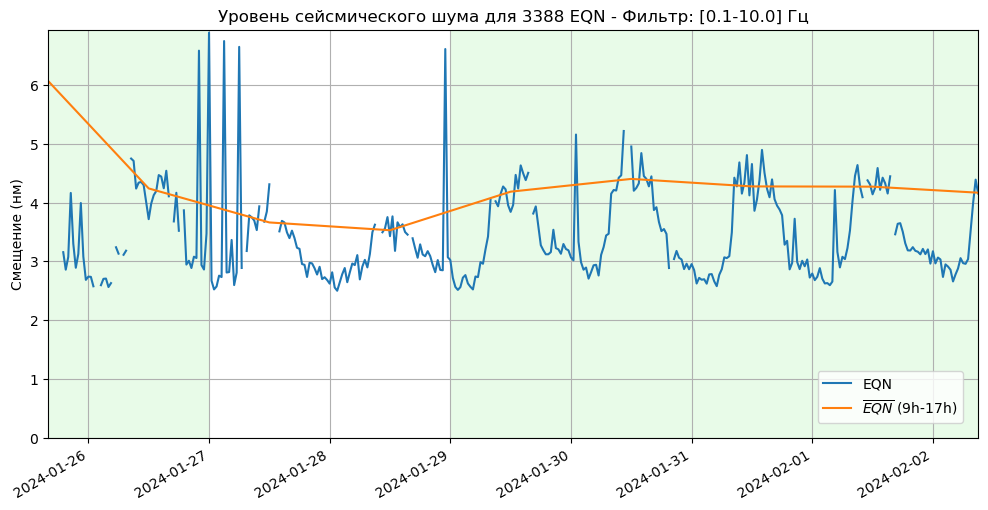

In [18]:
time_zone = "Europe/Moscow"
sitedesc = "in Moscow (Protvino, suburbian)"
# logo = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png'


args = {'band':"0.1-10.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'нм'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='timeseries',
                            **args)

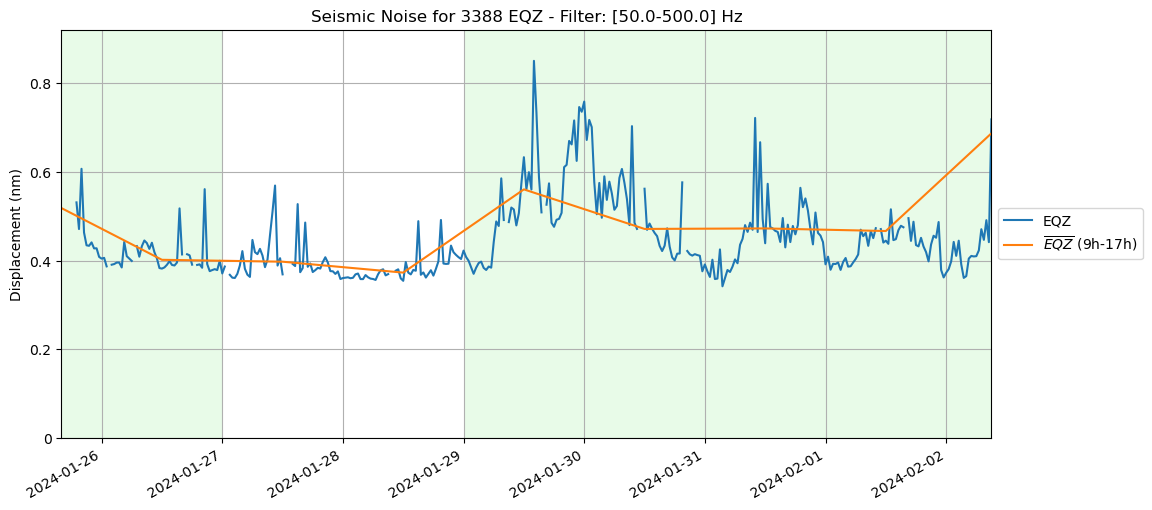

In [331]:
# displacement_RMS["EQZ"].loc[displacement_RMS["EQZ"]["50.0-600.0"]>2.5*10e-10]=np.nan
# displacement_RMS
time_zone = "Europe/Moscow"
sitedesc = "in Moscow (Protvino, suburbian)"
# logo = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png'


args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='timeseries',
                            **args)

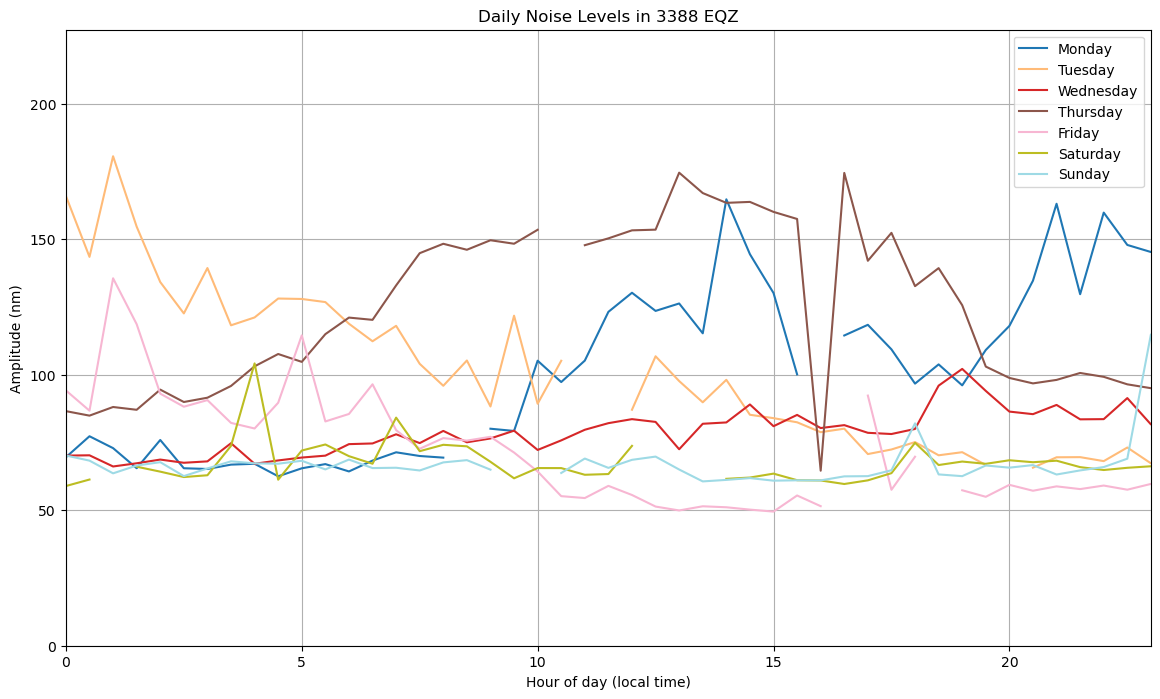

In [332]:
args = {'band':"0.1-50.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='dailyplots',
                            **args)

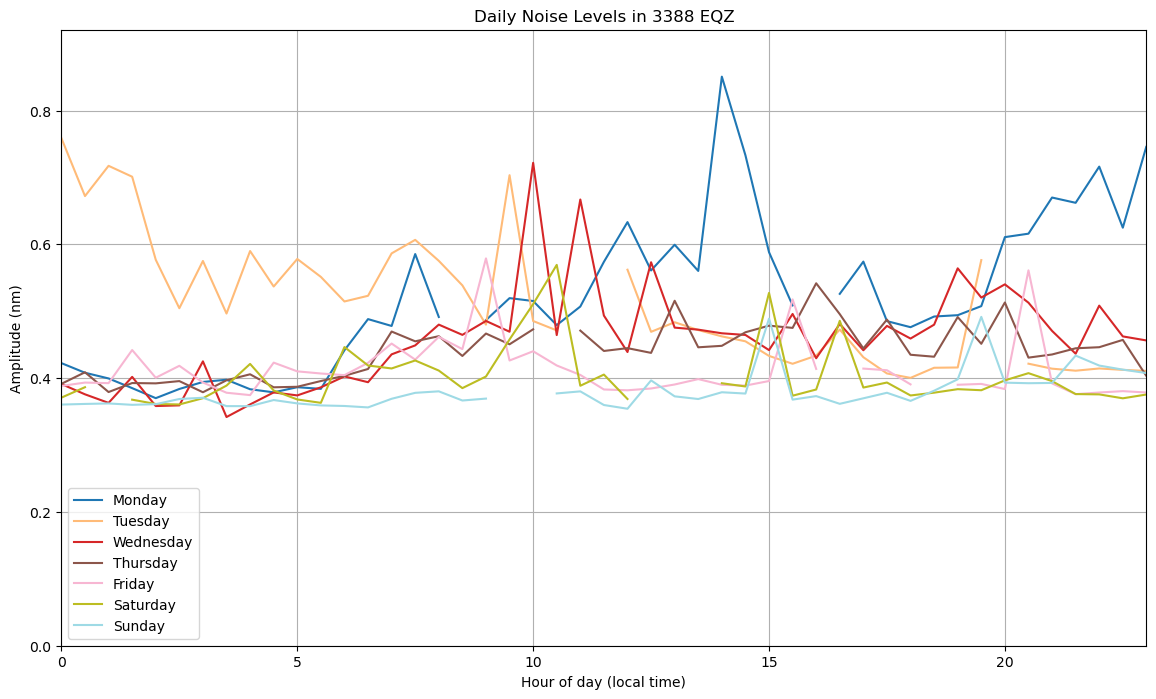

In [334]:
args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': {"2025-03-13":''},
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='dailyplots',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


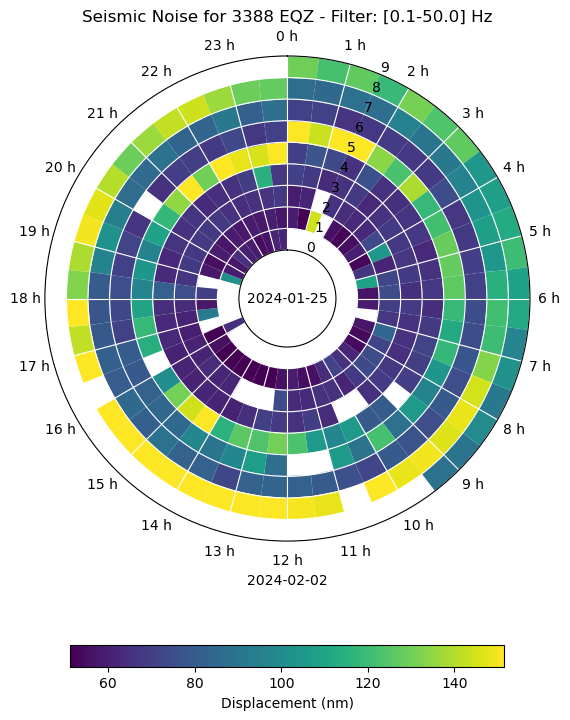

In [320]:
args = {'band':"0.1-50.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='clockmaps',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


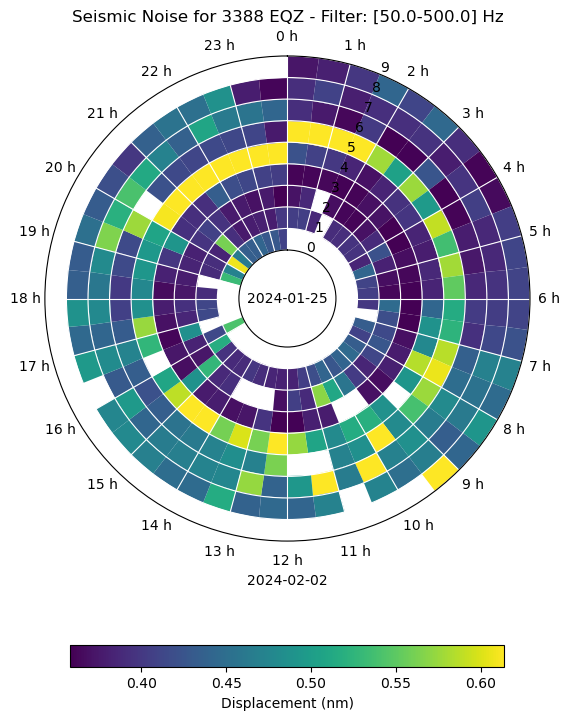

In [335]:
args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='clockmaps',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


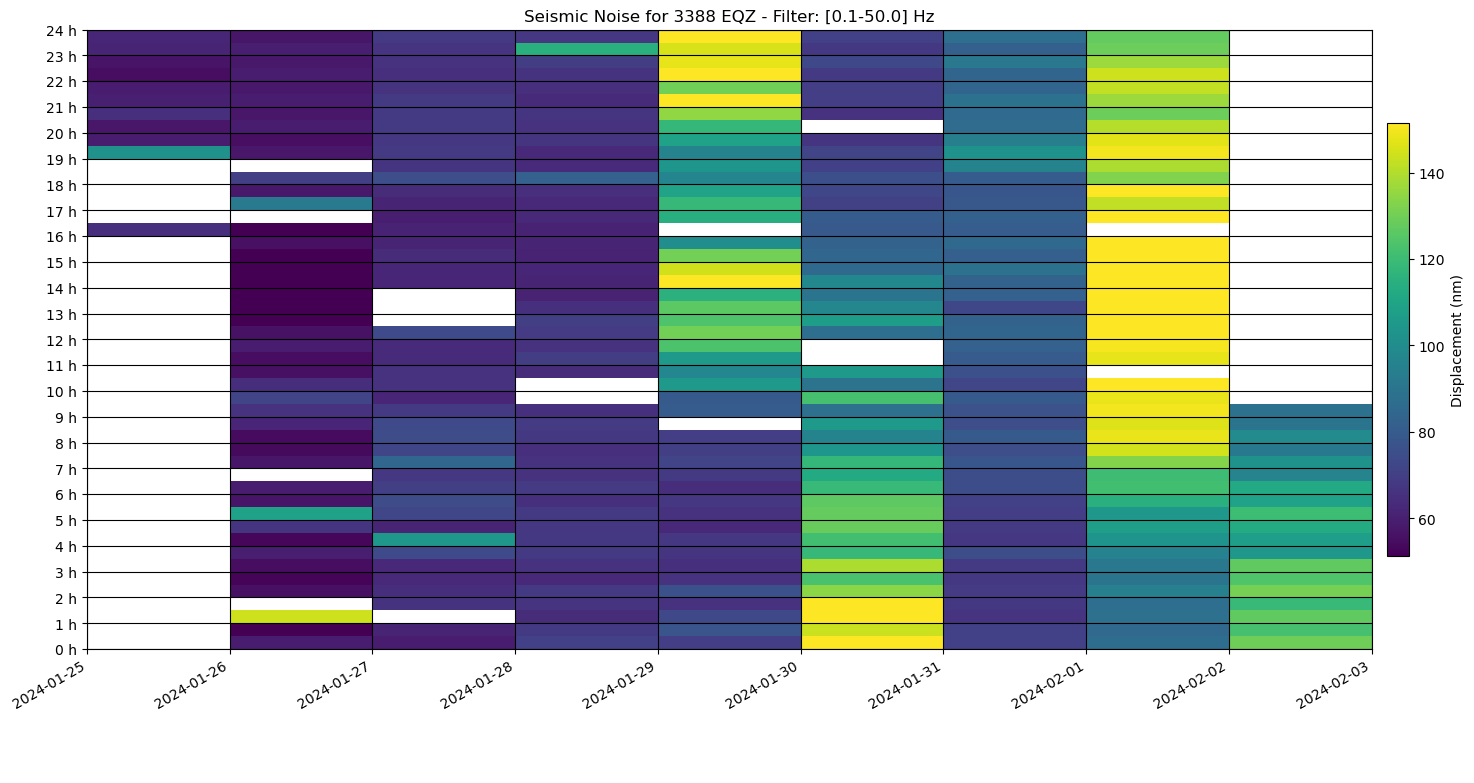

In [321]:
args = {'band':"0.1-50.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='gridmaps',
                            **args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


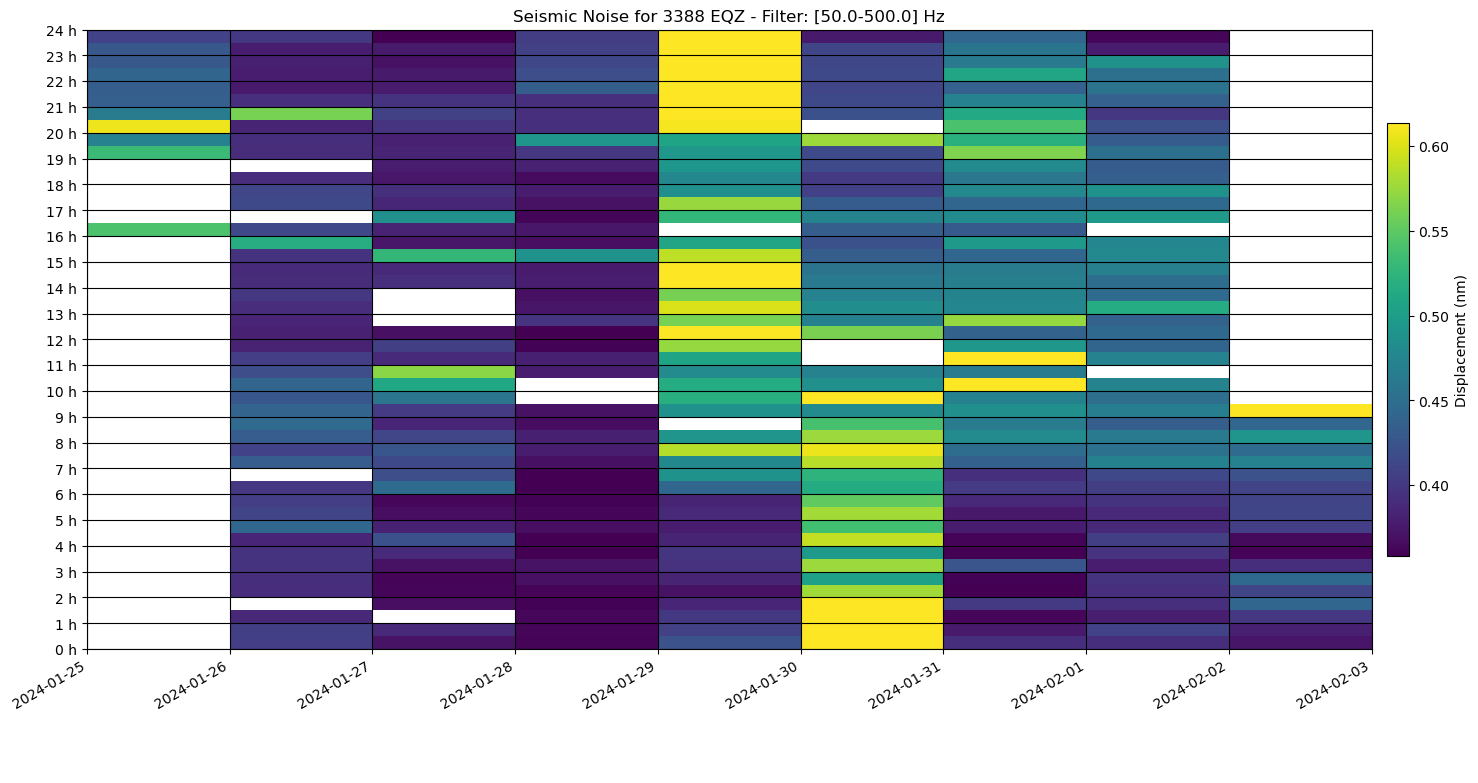

In [336]:
args = {'band':"50.0-500.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo': None,             # might be None or commented
        'bans': None,
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='gridmaps',
                            **args)